In [2]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [5]:
source('main.R')

data <- kaggle.house$loadData() 

df.combined <- 
    kaggle.house$getCombinedDataset(data$train, data$test) %>%
    (kaggle.house$na$fixAll) %>%
    rename(price = SalePrice) %>%
    mutate(
        log.price = log(price),
        sq.feat.price = price / GrLivArea
    )  

trainset <- 
    df.combined %>% 
    filter(dataSource == "train") %>%
    select(-dataSource)

trainset %>% nrow

trainset.cat <- trainset %>% 
    select(one_of(union(kaggle.house$getCategoricalColumnNames(.), 
                        c("price", "log.price", "sq.feat.price"))))

trainset.num <-  trainset %>% select_if(is.numeric)

trainset.cat %>% colnames
trainset.num %>% colnames

[1] 1460

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MSSubClass"    "MSZoning"      "Neighborhood" 
[37] "PavedDrive"    "PoolQC"        "RoofMatl"      "RoofStyle"    
[41] "SaleCondition" "SaleType"      "Street"        "Utilities"    
[45] "price"         "log.price"     "sq.feat.price"

[1] "LotFrontage"   "LotArea"       "OverallQual"   "OverallCond"  
 [5] "YearBuilt"     "YearRemodAdd"  "MasVnrArea"    "BsmtFinSF1"   
 [9] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "X1stFlrSF"    
[13] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[17] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[21] "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"    "GarageYrBlt"  
[25] "GarageCars"    "GarageArea"    "WoodDeckSF"    "OpenPorchSF"  
[29] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[33] "MiscVal"       "MoSold"        "YrSold"        "price"        
[37] "log.price"     "sq.feat.price"

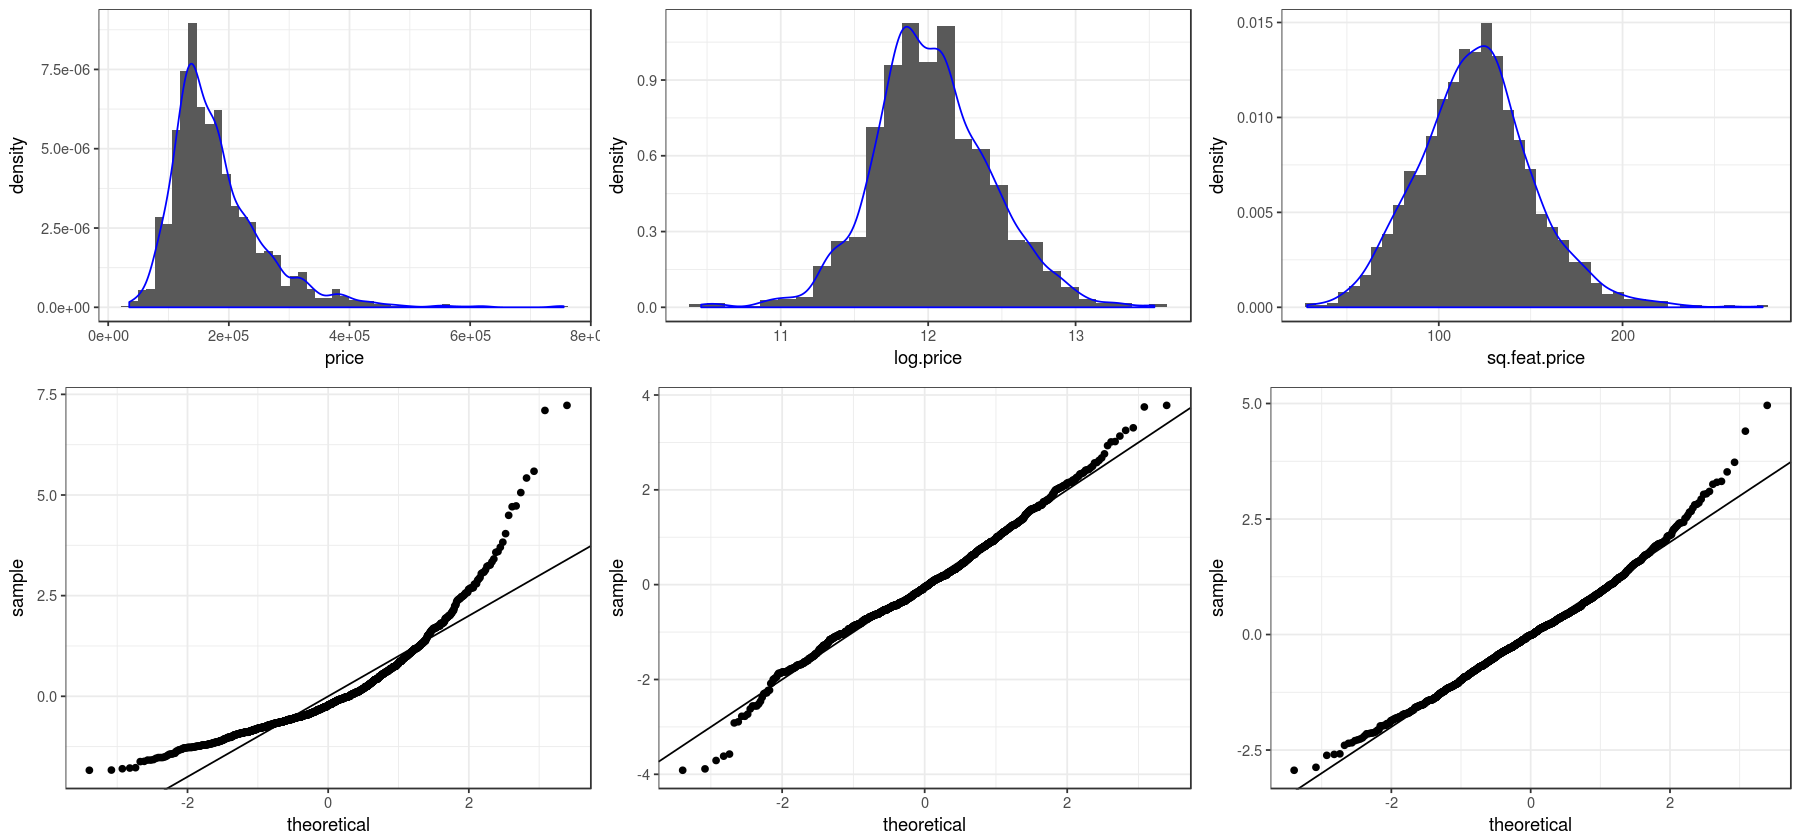

In [275]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(log.price)) +
    geom_histogram(aes(y=..density..), binwidth=0.12) +
    geom_density(color="blue") +
    theme_bw()

p3 <- trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        log.price.norm = (log.price - mean(log.price)) / sd(log.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=log.price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

x <- grid.arrange(p1, p2, p3, qq1, qq2, qq3, 
                  layout_matrix=rbind(c(1, 2, 3), 
                                      c(4, 5, 6)),
                 heights=c(45, 55))

In [6]:
log.price.vs.cat <- 
    trainset.cat %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

log.price.vs.cat %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,FireplaceQu,Foundation,GarageType,MSSubClass,BsmtFinType1
r2,0.546,0.477,0.465,0.457,0.306,0.294,0.256,0.249,0.246,0.211
r2.log,0.571,0.461,0.452,0.448,0.381,0.311,0.304,0.335,0.330,0.228
r2.sq.feat,0.388,0.237,0.291,0.234,0.177,0.065,0.197,0.155,0.364,0.234


var.name,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,GarageType,MSSubClass,FireplaceQu,Foundation,HeatingQC
r2,0.546,0.477,0.465,0.457,0.306,0.249,0.246,0.294,0.256,0.196
r2.log,0.571,0.461,0.452,0.448,0.381,0.335,0.330,0.311,0.304,0.234
r2.sq.feat,0.388,0.237,0.291,0.234,0.177,0.155,0.364,0.065,0.197,0.136


var.name,Neighborhood,MSSubClass,BsmtQual,ExterQual,BsmtFinType1,HouseStyle,KitchenQual,Foundation,BsmtExposure,GarageFinish
r2,0.546,0.246,0.465,0.477,0.211,0.086,0.457,0.256,0.150,0.306
r2.log,0.571,0.330,0.452,0.461,0.228,0.102,0.448,0.304,0.143,0.381
r2.sq.feat,0.388,0.364,0.291,0.237,0.234,0.234,0.234,0.197,0.183,0.177


In [7]:
log.price.vs.num <- 
    trainset.num %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

log.price.vs.num %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
r2,0.626,0.502,0.410,0.389,0.376,0.367,0.314,0.285,0.273,0.257
r2.log,0.668,0.491,0.463,0.424,0.375,0.356,0.354,0.286,0.344,0.320
r2.sq.feat,0.224,0.012,0.162,0.156,0.175,0.070,0.008,0.035,0.308,0.201


var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,YearBuilt,YearRemodAdd,TotRmsAbvGrd
r2,0.626,0.502,0.410,0.389,0.376,0.367,0.314,0.273,0.257,0.285
r2.log,0.668,0.491,0.463,0.424,0.375,0.356,0.354,0.344,0.320,0.286
r2.sq.feat,0.224,0.012,0.162,0.156,0.175,0.070,0.008,0.308,0.201,0.035


var.name,YearBuilt,OverallQual,YearRemodAdd,TotalBsmtSF,GarageCars,GarageArea,BsmtFinSF1,BedroomAbvGr,X2ndFlrSF,BsmtFullBath
r2,0.273,0.626,0.257,0.376,0.410,0.389,0.149,0.028,0.102,0.052
r2.log,0.344,0.668,0.320,0.375,0.463,0.424,0.138,0.044,0.102,0.056
r2.sq.feat,0.308,0.224,0.201,0.175,0.162,0.156,0.154,0.127,0.121,0.117


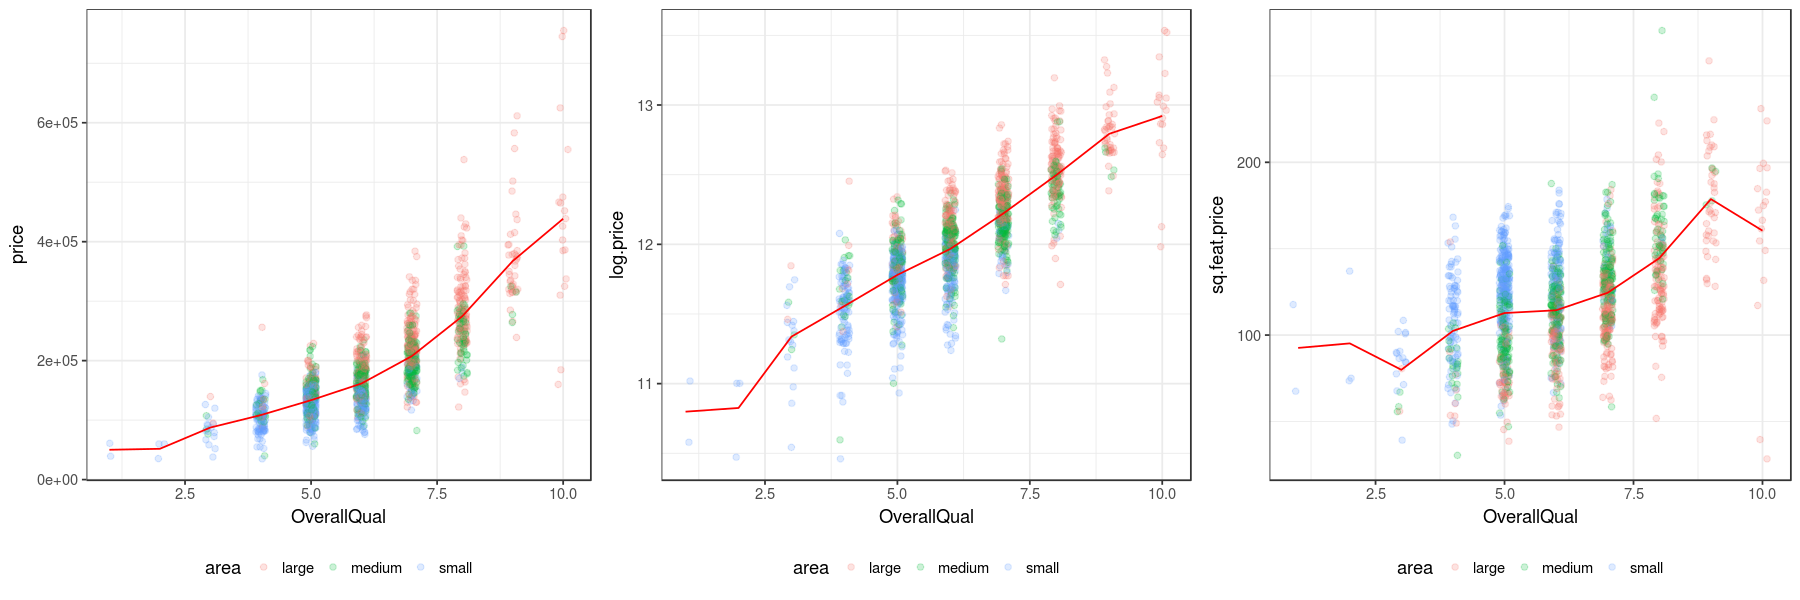

In [8]:
df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

p1 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=log.price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    df %>%
    ggplot(aes(x=OverallQual, y=sq.feat.price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

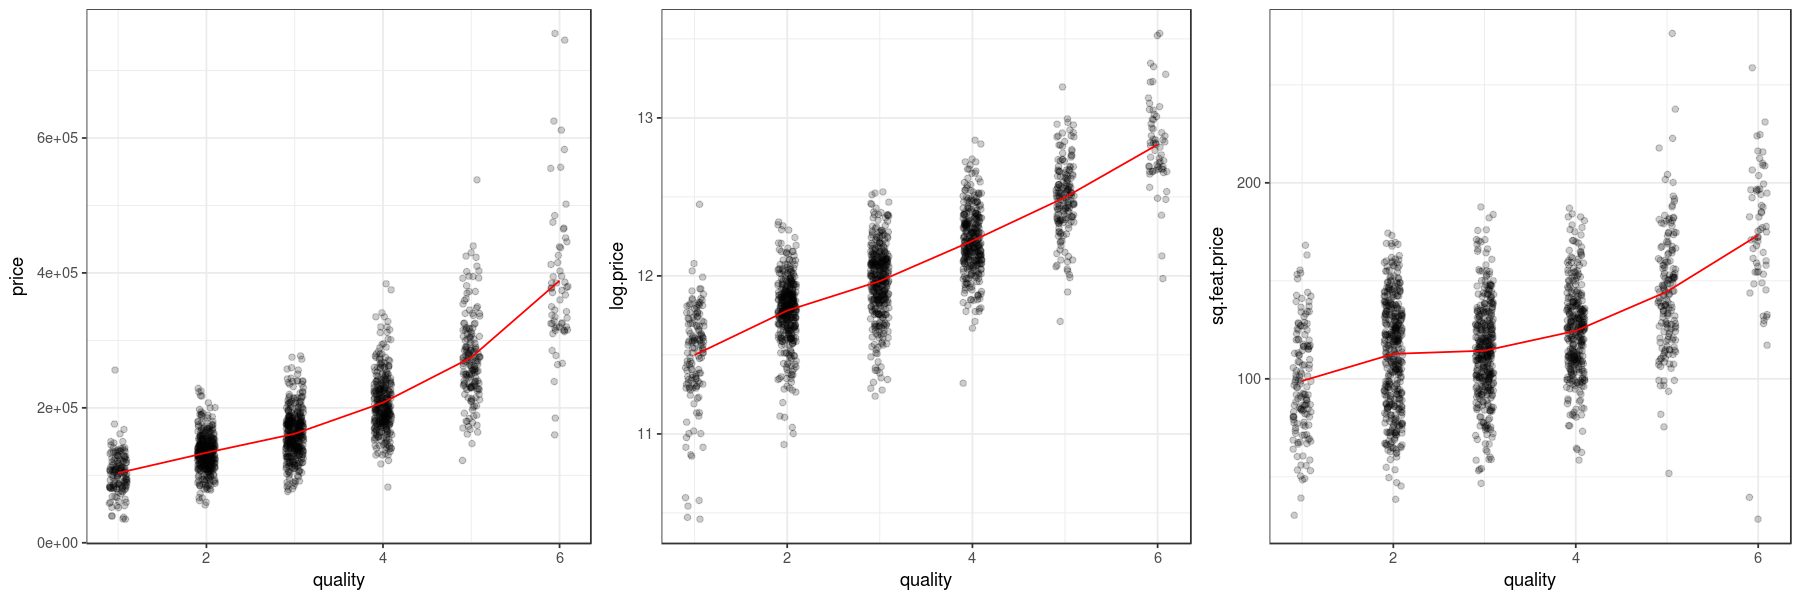

In [56]:
combine.levels.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 1,
            OverallQual %in% c(9, 10) ~ 6,
            TRUE ~ OverallQual - 3
        )
    )
}

p1 <- 
    trainset %>%
    (combine.levels.OverallQual) %>%
    ggplot(aes(x=quality, y=price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    trainset %>%
    (combine.levels.OverallQual) %>%
    ggplot(aes(x=quality, y=log.price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    trainset %>%
    (combine.levels.OverallQual) %>%
    ggplot(aes(x=quality, y=sq.feat.price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

In [57]:
trainset.num %>% 
    select(-OverallQual, -price, -log.price, -sq.feat.price) %>% 
    cor(trainset.num$OverallQual) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr=V1) %>%
    left_join(log.price.vs.num, by='var.name') %>%
    mutate(`r2.log/corr` = r2.log/corr) %>%
    arrange(desc(abs(`r2.log/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    head(10)

var.name,corr,r2,r2.log,r2.sq.feat,r2.log/corr
GrLivArea,0.593,0.502,0.491,0.012,0.828
GarageCars,0.601,0.410,0.463,0.162,0.771
GarageArea,0.562,0.389,0.424,0.156,0.754
X1stFlrSF,0.476,0.367,0.356,0.070,0.748
TotalBsmtSF,0.538,0.376,0.375,0.175,0.697
TotRmsAbvGrd,0.427,0.285,0.286,0.035,0.669
FullBath,0.551,0.314,0.354,0.008,0.643
LotArea,0.106,0.070,0.066,0.009,0.624
Fireplaces,0.397,0.218,0.240,0.022,0.605
YearBuilt,0.572,0.273,0.344,0.308,0.601


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.4912982,0.4909493,0.2850001,1408.119,3.060209e-216,2,-237.9615,481.923,497.7816,118.4261,1458


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5332721,0.532952,0.272989,1665.876,1.598465e-243,2,-175.097,356.1941,372.0526,108.6546,1458


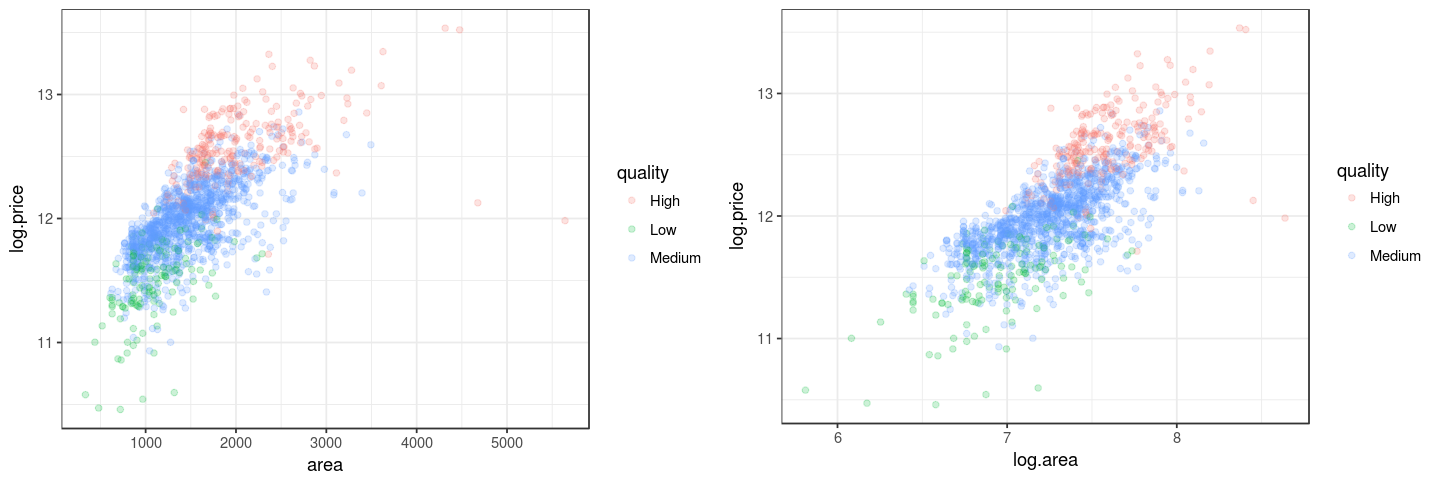

In [58]:
df <- 
    trainset %>%
    mutate(
        area = GrLivArea,
        log.area = log(GrLivArea),
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 'Low',
            OverallQual %in% c(5, 6, 7) ~ 'Medium',
            TRUE ~ 'High'
        )
    )

p1 <- 
    df %>%
    ggplot() +
    geom_point(aes(x=area, y=log.price, color=quality), alpha=0.2) +
    theme_bw()

p2 <- 
    df %>%
    ggplot() +
    geom_point(aes(x=log.area, y=log.price, color=quality), alpha=0.2) +
    theme_bw()

lm(log.price ~ GrLivArea, data=df) %>% glance
lm(log.price ~ log.area, data=df) %>% glance

options(repr.plot.width = 12, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

In [53]:
df <-
    trainset.num %>%
    mutate(log.area = log(GrLivArea)) %>%
    select(-GrLivArea, -price, -log.price, -sq.feat.price) 

df %>% 
    select(-log.area) %>%
    cor(df$log.area) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr=V1) %>%
    left_join(log.price.vs.num, by='var.name') %>%
    mutate(`r2.log/corr` = r2.log/corr) %>%
    filter(r2.log > 0.1) %>% 
    arrange(desc(abs(`r2.log/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3)))

var.name,corr,r2,r2.log,r2.sq.feat,r2.log/corr
YearBuilt,0.236,0.273,0.344,0.308,1.461
OverallQual,0.614,0.626,0.668,0.224,1.088
YearRemodAdd,0.311,0.257,0.320,0.201,1.027
GarageCars,0.496,0.410,0.463,0.162,0.933
GarageArea,0.476,0.389,0.424,0.156,0.890
TotalBsmtSF,0.436,0.376,0.375,0.175,0.860
BsmtFinSF1,0.164,0.149,0.138,0.154,0.842
X1stFlrSF,0.551,0.367,0.356,0.070,0.646
GarageYrBlt,0.208,0.068,0.122,0.053,0.587
FullBath,0.653,0.314,0.354,0.008,0.542


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.6525096,0.6522713,0.2355509,2737.799,0,2,40.25973,-74.51946,-58.66089,80.896,1458


term,estimate,std.error,statistic,p.value
(Intercept),11.2551955,0.015934879,706.32452,0
quality,0.2473075,0.004726466,52.32398,0


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5332721,0.532952,0.272989,1665.876,1.598465e-243,2,-175.097,356.1941,372.0526,108.6546,1458


term,estimate,std.error,statistic,p.value
(Intercept),5.6681247,0.15588850,36.36012,1.396337e-206
log.area,0.8745354,0.02142674,40.81515,1.598465e-243


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7446168,0.7442662,0.2020033,2124.076,0,3,265.0792,-522.1584,-501.0137,59.45338,1457


term,estimate,std.error,statistic,p.value
(Intercept),8.1576050,0.135816682,60.06335,0.000000e+00
log.area,0.4563959,0.019909544,22.92347,1.480482e-99
quality,0.1767386,0.005089818,34.72396,5.230032e-193


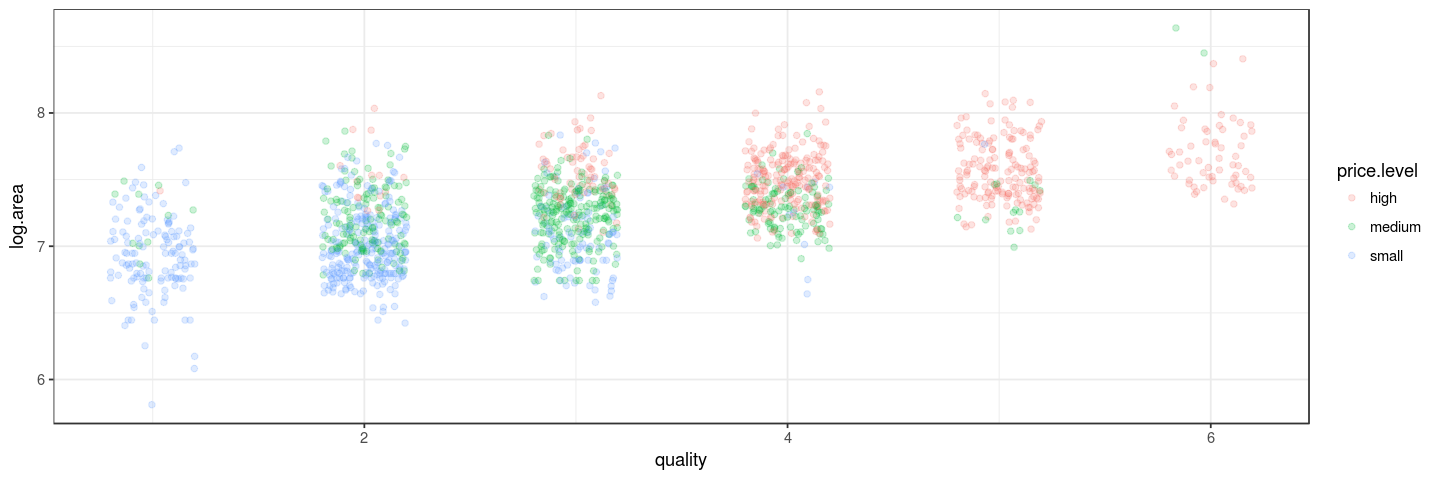

In [83]:
df <-
    trainset %>%
    select(log.price, OverallQual, GrLivArea) %>%
    (combine.levels.OverallQual) %>%
    mutate(
        log.area = log(GrLivArea),
        price.level = case_when(
            log.price <= quantile(log.price, 0.33) ~ 'small',
            log.price > quantile(log.price, 0.33)  & 
                log.price < quantile(log.price, 0.66)~ 'medium',
            TRUE ~ 'high'
        )
    ) %>%
    select(quality, log.area, log.price, price.level)

mod <- lm(log.price ~ quality, data=df) 
mod %>% glance
mod %>% tidy

mod <- lm(log.price ~ log.area, data=df)
mod %>% glance
mod %>% tidy

mod <- lm(log.price ~ log.area + quality, data=df)
mod %>% glance
mod %>% tidy

df %>%
    ggplot() +
    geom_jitter(aes(x=quality, y=log.area, color=price.level), , alpha=0.2, width=0.2, height=0) +
    theme_bw()

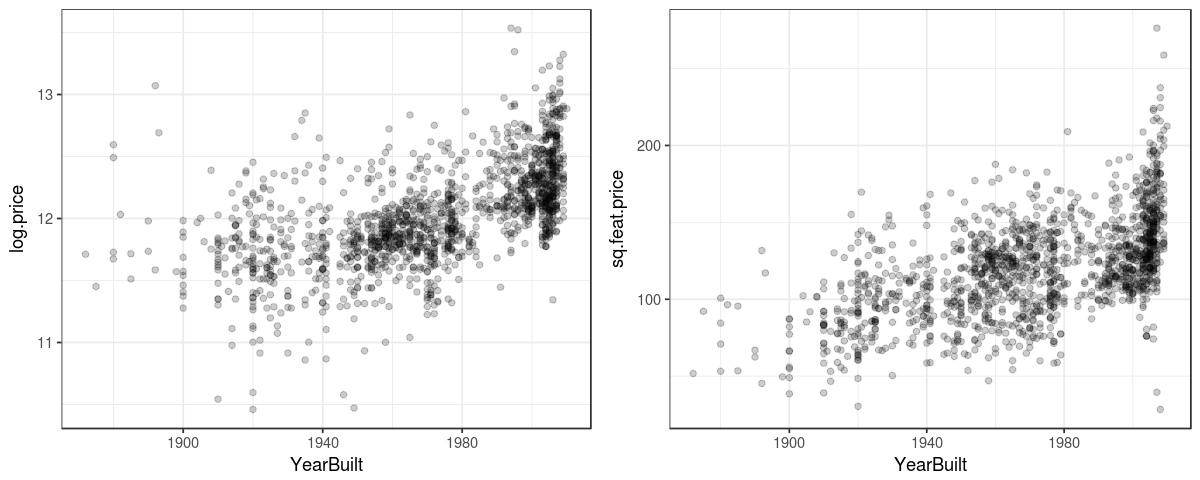

In [340]:
p1 <- 
    trainset %>%
    ggplot() +
    geom_point(aes(x=YearBuilt, y=log.price), alpha=0.2) +
    theme_bw()

p2 <-
    trainset %>%
    mutate(sq.feat.price = price / GrLivArea) %>%
    ggplot() +
    geom_point(aes(x=YearBuilt, y=sq.feat.price), alpha=0.2) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

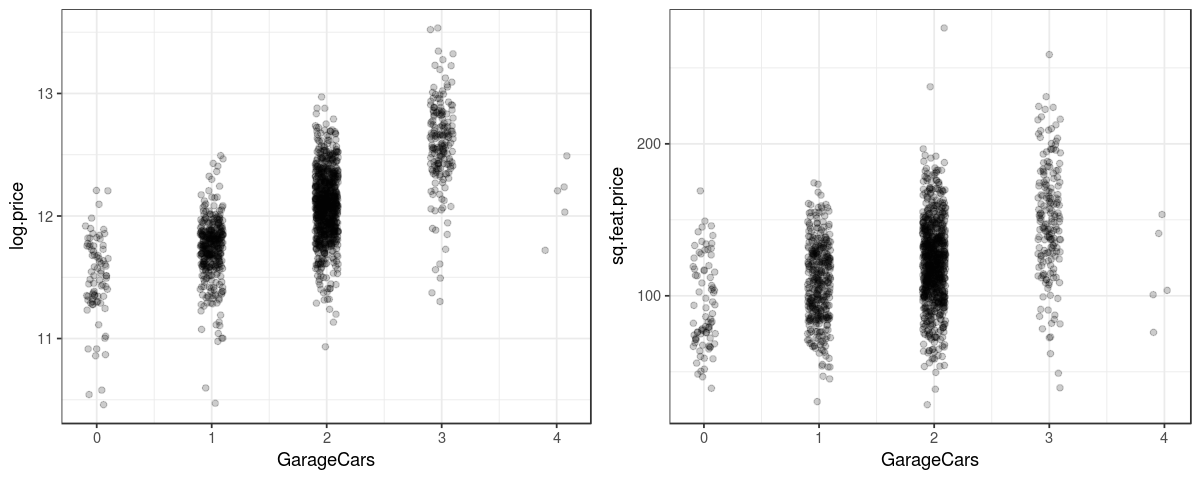

In [155]:
p1 <-
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=GarageCars, y=log.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

p2 <- 
    trainset %>%
    mutate(sq.feat.price = price / GrLivArea) %>%
    ggplot() +
    geom_jitter(aes(x=GarageCars, y=sq.feat.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))